<a href="https://colab.research.google.com/github/mmcastillo/al112248/blob/main/3D_AResUNet_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modificaciones:
Se disminuye a 3 el número de submuestreos (downsampling)

In [1]:
pip install patchify

In [2]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.13.0
2.13.1


In [3]:
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from google.colab import drive
drive.mount('/content/drive/');
import os
from keras.models import Model
from keras import layers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate, Flatten, Dense
import random

Mounted at /content/drive/


In [4]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)
            if image.shape[3]==3:

                  image = image[:,:,:,0]
                  image = np.expand_dims(image,-1)

            images.append(image)
    images = np.array(images)

    return(images)

In [5]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            X = np.float32(X)
            Y = np.float32(Y)

            list_lbl=[]
            for i in range(0,len(Y)):
              if np.unique(Y[i,:,:,:,:]).shape[0]==1:
                lbl=0
              else:
                lbl=1
              list_lbl.append(lbl)
            lbl = np.array(list_lbl)
            lbl = np.float32(lbl)

            yield [X],[Y,lbl] #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [6]:
train_img_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/pos_neg/imgs/';
train_mask_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/pos_neg/mask/';
train_img_list_comp = os.listdir(train_img_dir)
train_mask_list_comp = os.listdir(train_mask_dir)

val_img_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/val/imgs/';
val_mask_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/val/masks/';
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

#Se toma una muestra de la lista de patches de entrenamiento para hacer pruebas
train_img_list = []
train_mask_list = []
indices_aleatorios = random.sample(range(0,len(train_img_list_comp)),200)
for i in indices_aleatorios:
  train_img_list.append(train_img_list_comp[i])
  train_mask_list.append(train_mask_list_comp[i])

print('para entrenar se toman', len(train_img_list),'imágenes y para validación', len(val_img_list))
print('para entrenar se toman', len(train_mask_list),'máscaras y para validación', len(val_mask_list))

para entrenar se toman 200 imágenes y para validación 37
para entrenar se toman 200 máscaras y para validación 37


In [7]:
print(train_img_list)
print(train_mask_list)

['54_img52.npy', '51_21.npy', '38_img9.npy', '59_img22.npy', '116_38.npy', '1_6.npy', '148_33.npy', '80_24.npy', '31_img12.npy', '36_img105.npy', '58_img36.npy', '62_img9.npy', '17_16.npy', '90_15.npy', '27_img93.npy', '38_19.npy', '20_img64.npy', '44_30.npy', '102_20.npy', '96_27.npy', '60_img128.npy', '56_img94.npy', '141_32.npy', '150_36.npy', '35_img98.npy', '44_img27.npy', '66_img85.npy', '3_23.npy', '48_img28.npy', '50_img38.npy', '40_32.npy', '67_19.npy', '29_img24.npy', '25_img54.npy', '24_7.npy', '121_37.npy', '10_4.npy', '19_10.npy', '22_img68.npy', '5_30.npy', '46_img115.npy', '13_img19.npy', '69_45.npy', '109_35.npy', '92_5.npy', '68_img120.npy', '79_35.npy', '24_img43.npy', '19_img95.npy', '13_img127.npy', '151_37.npy', '38_img104.npy', '52_img26.npy', '3_img32.npy', '127_1.npy', '13_img36.npy', '57_19.npy', '65_img90.npy', '99_45.npy', '131_9.npy', '31_27.npy', '9_img25.npy', '2_21.npy', '12_img123.npy', '33_img110.npy', '30_img78.npy', '59_img83.npy', '105_40.npy', '9_im

In [8]:
n = 0; m = 0
for i in range(0,len(train_img_list)):
  mask = np.load(train_mask_dir + train_mask_list[i])
  if np.unique(mask).shape[0]==2:
    n = n + 1
  else:
    m = m + 1
print('se tienen', n,'patches positivos','y ', m ,'patches negativos.      ', n/n,':', round(m/n,1))

se tienen 79 patches positivos y  121 patches negativos.       1.0 : 1.5


In [9]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, 7)

(2, 64, 64, 64, 1)
(2, 64, 64, 64, 1)
[0. 1.]


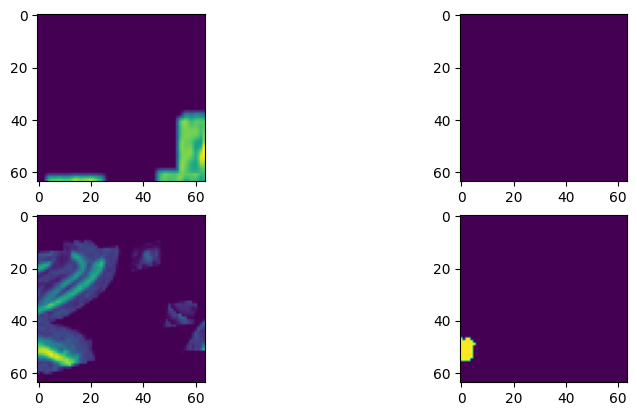

In [10]:
[img],[mask,lbl] = train_img_datagen.__next__()
print(img.shape)
print(mask.shape)
print(lbl)
plt.figure(figsize =(10,10))
plt.subplot(4,2,1)
plt.imshow(np.max(img[0,:,:,:,0],2));
plt.subplot(4,2,2)
plt.imshow(np.max(mask[0,:,:,:,0],2));
plt.subplot(4,2,3)
plt.imshow(np.max(img[1,:,:,:,0],2));
plt.subplot(4,2,4)
plt.imshow(np.max(mask[1,:,:,:,0],2));

In [11]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

def gen_dice_loss(y_true, y_pred):  #Generalized Dice Loss
    num, den = 0, 0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    wg = 1/((K.sum(y_true_f)+ 1e-10)**2)
    I1 = K.sum(y_true_f * y_pred_f)
    I2 = K.sum(y_pred_f + y_true_f)
    num += wg*I1
    den += wg*I2
    GDLoss = 1 - 2*((num + 1e-10)/(den + 1e-10))
    return GDLoss

def dice_loss(y_true, y_pred):  #Generalized Dice Loss
    num, den = 0, 0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    wg=1
    I1 = K.sum(y_true_f * y_pred_f)
    I2 = K.sum(y_pred_f + y_true_f)
    num += wg*I1
    den += wg*I2
    DLoss = 1 - 2*((num + 1e-10)/(den + 1e-10))
    return DLoss


def diceCEloss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
      y_pred = tf.math.sigmoid(y_pred)
      numerator = 2 * tf.reduce_sum(y_true * y_pred)
      denominator = tf.reduce_sum(y_true + y_pred)

      return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    o = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

## Modelo 3D Attention ResUNet con clasificador auxiliar

In [13]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=True):

    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=-1)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=-1)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv3D(size, kernel_size=(1, 1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=-1)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=True):

    x = layers.Conv3D(out_size, (1, 1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv3D(inter_shape, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv3D(inter_shape, (1, 1, 1), padding='same')(gating)
    upsample_g = layers.Conv3DTranspose(inter_shape, (3, 3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2], shape_theta_x[3] // shape_g[3]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv3D(1, (1, 1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling3D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2], shape_x[3] // shape_sigmoid[3]))(sigmoid_xg)  # 32


    y = layers.multiply([upsample_psi, x])

    result = layers.Conv3D(shape_x[4], (1, 1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def AResUNetAC(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):

    '''
    Residual UNet, with attention + auxiliary classifier

    '''

    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter (tamaño del kernel = 3,3,3)
    UP_SAMP_SIZE = 2 # size of upsampling filters

    # input data
    seg_input = layers.Input(input_shape, dtype=tf.float32, name='img_entrada')

    axis = 4

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_64 = res_conv_block(seg_input, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)       #64
    pool_32 = layers.MaxPooling3D(pool_size=(2,2,2))(conv_64)                                 #(32,32,32)
    # DownRes 2
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)     #128
    pool_16 = layers.MaxPooling3D(pool_size=(2,2,2))(conv_32)                                  #(16,16,16)
    # DownRes 3
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)     #256
    pool_8 = layers.MaxPooling3D(pool_size=(2,2,2))(conv_16)                                  #(8,8,8)

    # DownRes 4, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)     #512 (8,8,8)

    # UpRes 5, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 4*FILTER_NUM, batch_norm)                                                          #256
    att_16 = attention_block(conv_16, gating_16, 4*FILTER_NUM)
    up_16 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)    #(16,16,16)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 6
    gating_32 = gating_signal(up_conv_16, 2*FILTER_NUM, batch_norm)                                                          #128
    att_32 = attention_block(conv_32, gating_32, 2*FILTER_NUM)
    up_32 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)    #(32,32,32)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_64 = gating_signal(up_conv_32, FILTER_NUM, batch_norm)                                                           #64
    att_64 = attention_block(conv_64, gating_64, FILTER_NUM)
    up_64 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)   #(64,64,64)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    conv_final = layers.Conv3D(NUM_CLASSES, kernel_size=(1,1,1))(up_conv_64)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    segmentation_output = layers.Activation('sigmoid', name = 'seg_out')(conv_final)  #Change to softmax for multichannel

    #Clasificador auxiliar
    #Se define la salida del encoder como entrada del clasificador auxiliar
    encoder_output = conv_8
    classifier_input = layers.Flatten()(encoder_output)
    clf1 = layers.Dense(64, activation='relu')(classifier_input)
    clf2 = layers.Dense(128, activation='relu')(clf1)
    classification_output = layers.Dense(1, activation='softmax', name = 'clf_out')(clf2)

    combined_model = Model(inputs = [seg_input], outputs= [segmentation_output, classification_output], name="AttResUNetCA")

    return combined_model

In [14]:
IMG_HEIGHT = img.shape[1]
IMG_WIDTH  = img.shape[2]
IMG_DEPTH = img.shape[3]
IMG_CHANNELS = img.shape[4]

num_labels = 1  #Binary

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS)

AttResUnet_CA_model = AResUNetAC(input_shape, dropout_rate = 0.0, batch_norm = True)

In [18]:
def custom_segmentation_loss(y_true, y_pred):
    segmentation_true, classification_true = y_true
    segmentation_pred, classification_pred = y_pred

    # Define binary cross-entropy loss for the segmentation task
    segmentation_loss = gen_dice_loss(segmentation_true, segmentation_pred)

    # Create a mask based on the classification output
    mask = tf.cast(classification_true >= 0.5, dtype=tf.float32)

    # Apply the mask to the segmentation loss
    masked_segmentation_loss = segmentation_loss * mask

    return tf.reduce_mean(masked_segmentation_loss)

In [26]:
def custom_segmentation_loss(y_true, y_pred):
    segmentation_true, classification_true = y_true[0], y_true[1]
    segmentation_pred, classification_pred = y_pred[0], y_pred[1]

    # Define binary cross-entropy loss for the segmentation task
    segmentation_loss = gen_dice_loss(segmentation_true, segmentation_pred)

    # Create a mask based on the classification output
    mask = tf.cast(classification_true >= 0.5, dtype=tf.float32)

    # Apply the mask to the segmentation loss
    masked_segmentation_loss = segmentation_loss * mask

    return tf.reduce_mean(masked_segmentation_loss)

In [27]:
AttResUnet_CA_model.compile(tf.keras.optimizers.Adam(learning_rate = 0.00005),
                           loss={'seg_out': custom_segmentation_loss, 'clf_out': 'binary_crossentropy'},
                           metrics={'seg_out': [tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5), dice_coef], 'clf_out': 'accuracy'},
                           )
print(AttResUnet_CA_model.summary())

Model: "AttResUNetCA"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_entrada (InputLayer)    [(None, 64, 64, 64, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 64, 64, 64, 64)       1792      ['img_entrada[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64, 64)       256       ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 64, 64)       0         ['batch_normalizati

In [20]:
print(AttResUnet_CA_model.inputs)
print(AttResUnet_CA_model.outputs)

[<KerasTensor: shape=(None, 64, 64, 64, 1) dtype=float32 (created by layer 'img_entrada')>]
[<KerasTensor: shape=(None, 64, 64, 64, 1) dtype=float32 (created by layer 'seg_out')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'clf_out')>]


In [21]:
from tensorflow import math
num_modelo = 1

filepath = '/content/drive/MyDrive/DOCTORADO/AttResUNetCAux_' + str(num_modelo) + '.h5'

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=0.00001)

stop_callback = keras.callbacks.EarlyStopping(monitor='val_seg_out_dice_coef',mode = 'max' , patience=30)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_seg_out_dice_coef',
    verbose = 1,
    mode='max',
    save_best_only=True,
    initial_value_threshold=0.2
    )

ruta_hist = '/content/drive/MyDrive/DOCTORADO/'
csv_logger_callback = keras.callbacks.CSVLogger(ruta_hist + 'history_AttResUNetCAux_'+ str(num_modelo) + '.csv', separator=',', append=True)

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

history=AttResUnet_CA_model.fit(train_img_datagen,
          steps_per_epoch = steps_per_epoch,
          epochs = 50,
          verbose = 1,
          validation_data = val_img_datagen,
          validation_steps = val_steps_per_epoch,
          callbacks = [reduce_lr, stop_callback,
                       model_checkpoint_callback,
                       csv_logger_callback]
          )

Epoch 1/50
 51/100 [==============>...............] - ETA: 1:10 - loss: 0.9210 - seg_out_loss: 9.0977e-04 - clf_out_loss: 0.9201 - seg_out_binary_io_u_3: 0.0022 - seg_out_dice_coef: 0.0031 - clf_out_accuracy: 0.4118

In [ ]:
num_modelo = 1

filepath = '/content/drive/MyDrive/DOCTORADO/AttResUNetCAux_' + str(num_modelo) + '.h5'

from keras.models import load_model
AttResUnet_CA_model.load_weights(filepath)

In [ ]:
#plot the training and validation IoU and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

plt.plot(epochs, train_dice_coef, 'y', label='Training DSC')
plt.plot(epochs, val_dice_coef, 'r', label='Validation DSC')
plt.title('Training and validation DSC')
plt.xlabel('Epochs')
plt.ylabel('DSC')
plt.legend()
plt.show()

## Visualizar resultados con el conjunto de validación

In [ ]:
val_img_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/val_aneurismas_completos/imgs/';
val_mask_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/val_aneurismas_completos/masks/';
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [ ]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, 2)

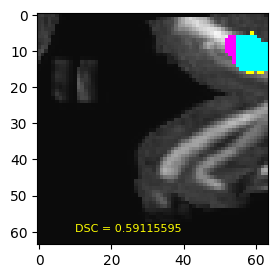

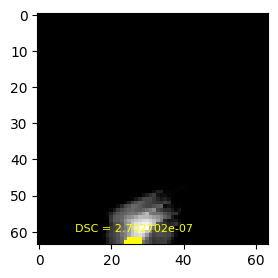

In [ ]:
img,mask = val_img_datagen.__next__()
prediction = AttResUnet_CA_model.predict(img,verbose=0)
prediction = prediction > 0.5

prediction = AttResUnet_CA_model.predict(img,verbose=0)
prediction = prediction > 0.5

for caso in range(batch_size):
  img_caso = img[caso,:,:,:,0]
  mask_caso = mask[caso,:,:,:,0]
  ypred = prediction[caso,:,:,:,0]

  ytrue = tf.convert_to_tensor(mask[caso,:,:,:,:],dtype='float32')
  ypred = tf.convert_to_tensor(prediction[caso,:,:,:,:],dtype='float32')
  dice = dice_coef(ytrue, ypred).numpy()

  imagen_rgb = np.stack((img_caso,)*3, axis=-1)
  imagen_rgb = np.max(imagen_rgb,2)
  ypredmip = np.max(ypred,2)
  masktestmip = np.max(mask_caso,2)

  for i in range(ypredmip.shape[0]):
            for j in range(ypredmip.shape[1]):
                if ypredmip[i,j] != 0:
                  if ypredmip[i,j] == masktestmip[i,j]:
                    imagen_rgb[i,j,0] = 0
                    imagen_rgb[i,j,1] = 1
                    imagen_rgb[i,j,2] = 1
                  else:
                    imagen_rgb[i,j,0] = 1
                    imagen_rgb[i,j,1] = 0
                    imagen_rgb[i,j,2] = 1
                else:
                  if masktestmip[i,j] == 1:
                    imagen_rgb[i,j,0] = 1
                    imagen_rgb[i,j,1] = 1
                    imagen_rgb[i,j,2] = 0
  plt.figure(figsize=(3,3))
  plt.imshow(imagen_rgb)


  text = 'DSC = ' + str(dice)
  pos_x = 10
  pos_y = 60
  plt.text(pos_x, pos_y, text, color='yellow', fontsize=8)

  #legend_labels = ['TP', 'FP', 'FN']
  #legend_colors = [[0,1,1] , [1,0,1] , [1,1,0]]
  #legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in legend_colors]
  #plt.legend(legend_patches, legend_labels, loc='upper left')

In [ ]:
#Carga conjunto de prueba
ruta_TOF = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_Preproc_Test/imgs/'
lista_archivos_TOF = os.listdir(ruta_TOF)
imgs_test =[]

for i in range(9):#(len(lista_archivos_TOF)):
  temp = np.load(ruta_TOF + lista_archivos_TOF[i])
  imgs_test.append(temp)

#Carga etiquetas de entrenamiento
ruta_mascaras = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_Preproc_Test/mask/'
lista_archivos_mascaras = os.listdir(ruta_mascaras)
masks_test =[]

for i in range(9):#len(lista_archivos_mascaras)):
  temp = np.load(ruta_mascaras + lista_archivos_mascaras[i])
  masks_test.append(temp)

imgs_test = np.array(imgs_test)
masks_test = np.array(masks_test)

In [ ]:
imgs_test.shape

(9, 512, 512, 128)

In [ ]:
print(imgs_test.shape)
masks_test = masks_test[:,:,:,:,0]
print(masks_test.shape)

(9, 512, 512, 128)
(9, 512, 512, 128)


64/64 [==============================] - 22s 347ms/step
0.22982678
64/64 [==============================] - 23s 357ms/step
1.0881392e-09
64/64 [==============================] - 23s 367ms/step
1.7448961e-09
64/64 [==============================] - 24s 374ms/step
1.858736e-09
64/64 [==============================] - 23s 369ms/step
2.0068232e-09
64/64 [==============================] - 23s 368ms/step
1.0729614e-09
64/64 [==============================] - 23s 372ms/step
0.14011079
64/64 [==============================] - 23s 370ms/step
0.15683979
64/64 [==============================] - 23s 369ms/step
1.8832392e-08


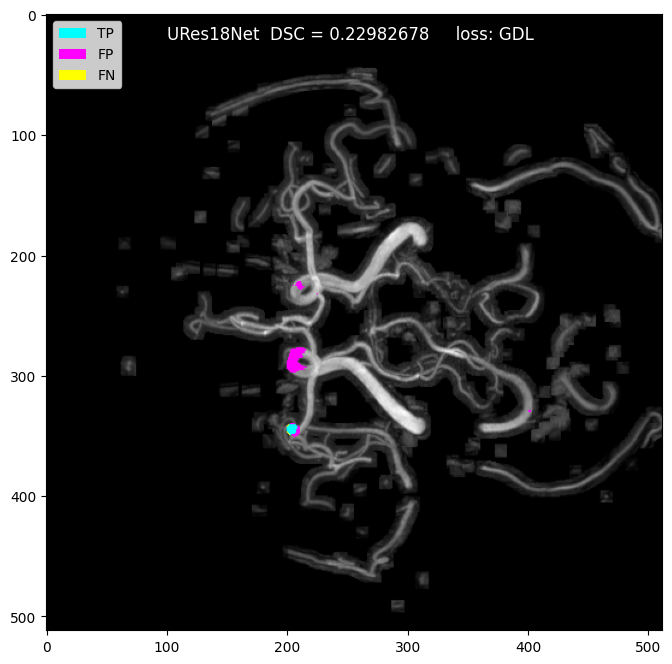

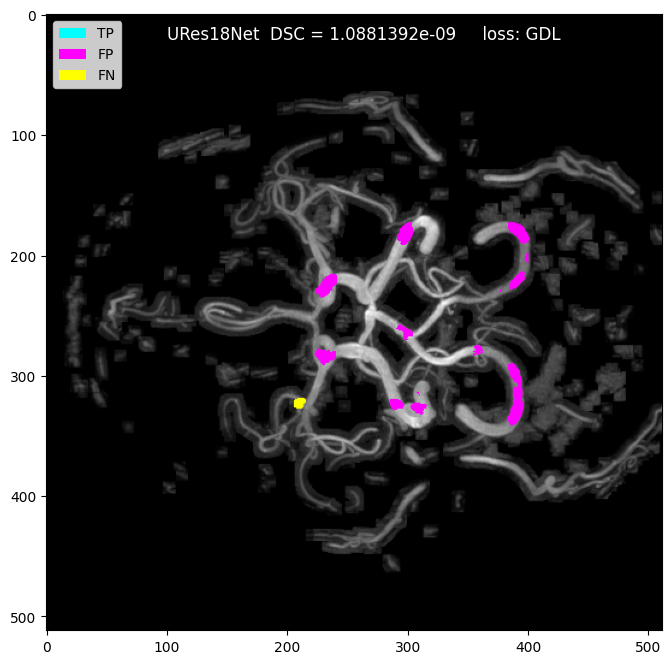

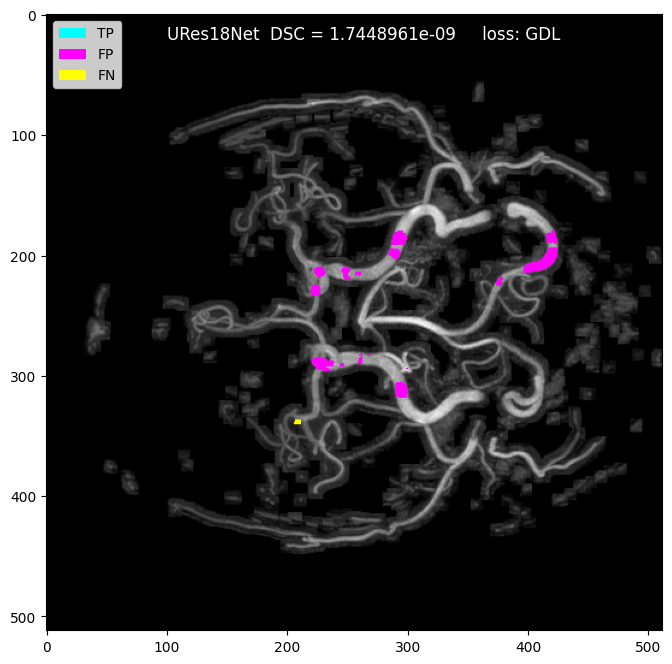

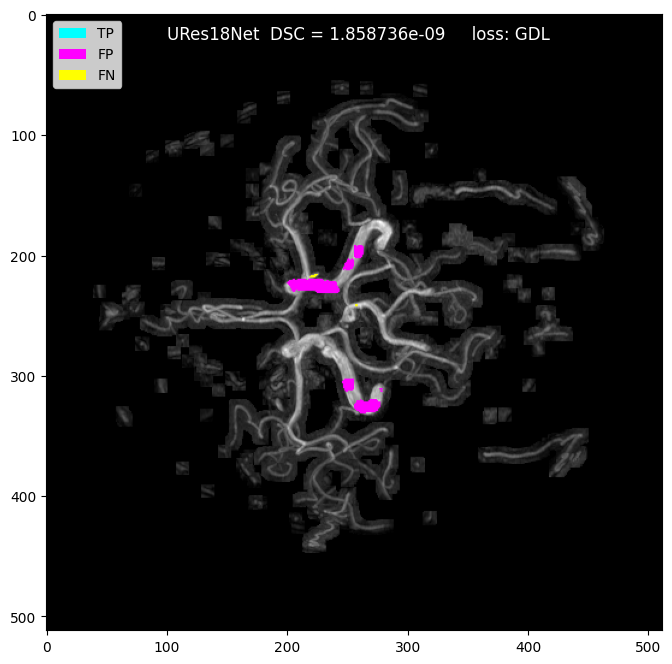

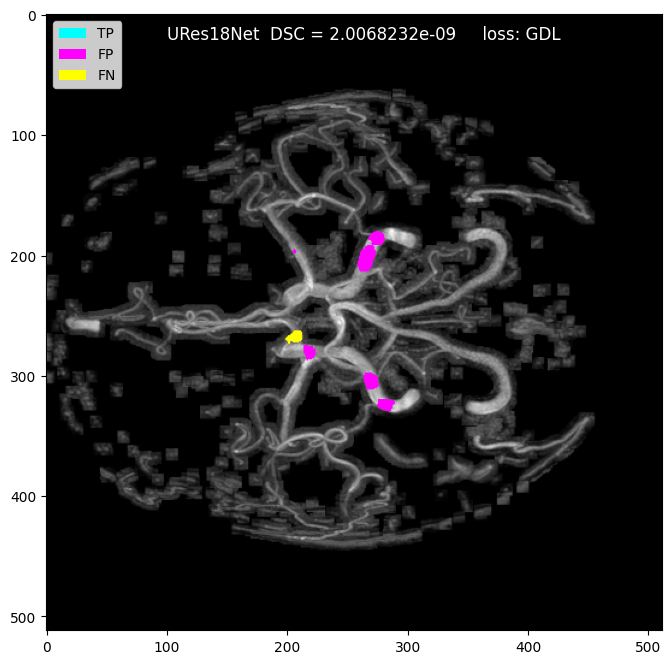

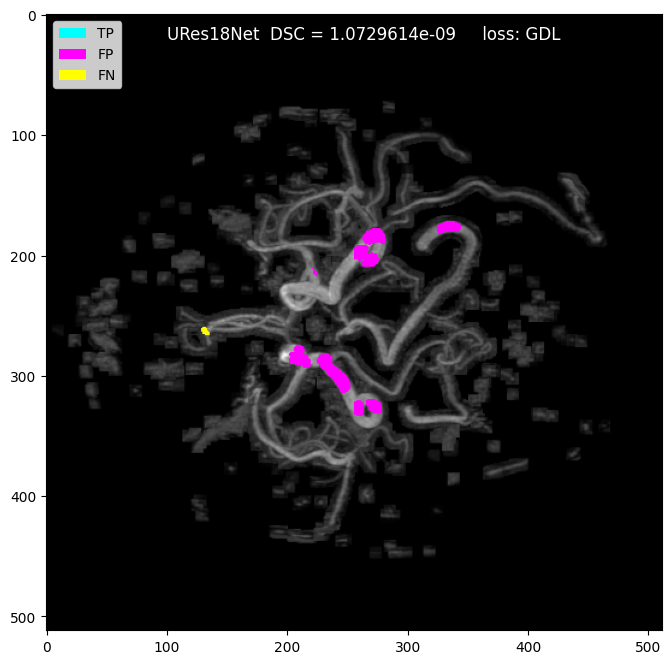

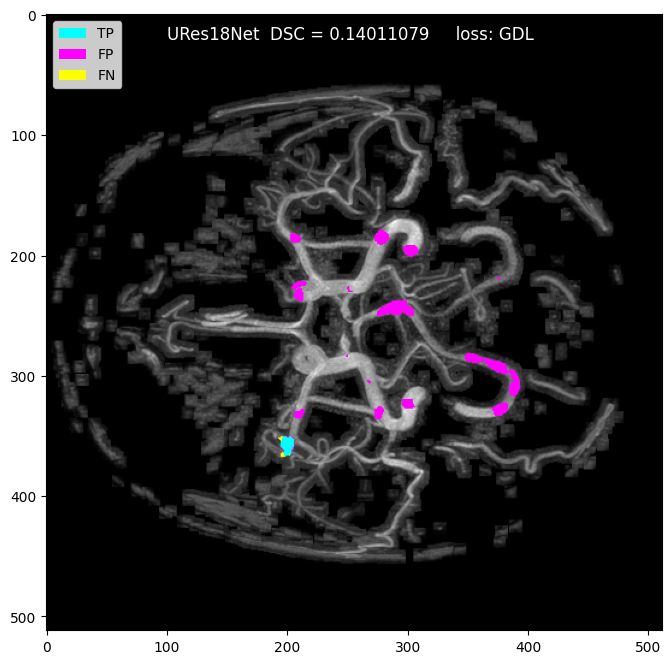

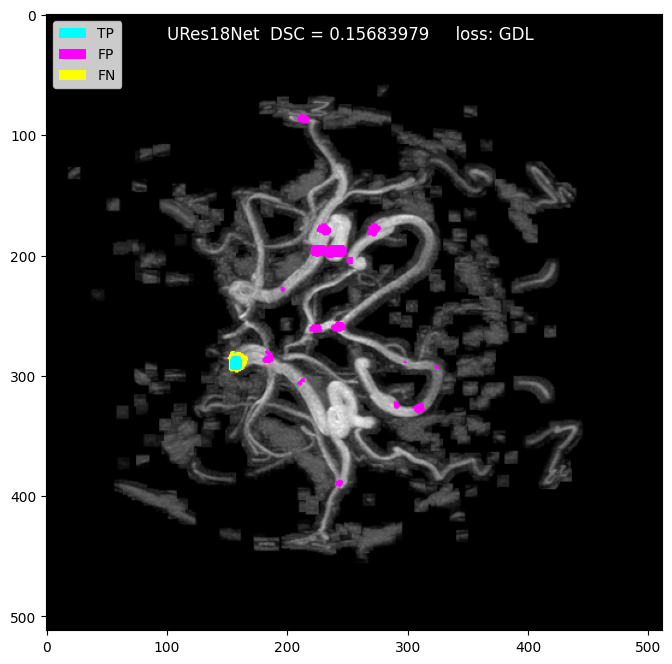

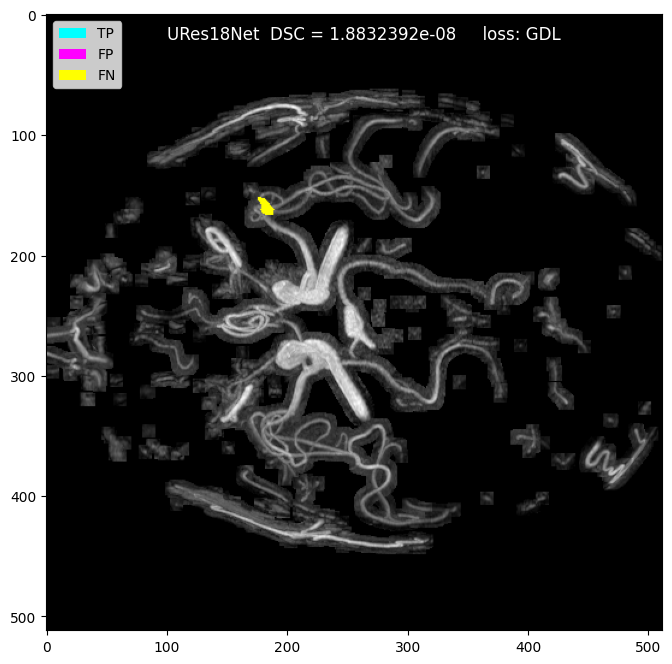

In [ ]:
patch_size = 64
ypredict =[]

for caso in range(imgs_test.shape[0]):
  img_patches = patchify(imgs_test[caso,:,:,:],(patch_size,patch_size,patch_size), step=64)
  mask_patches = patchify(masks_test[caso,:,:],(patch_size,patch_size,patch_size), step=64)

  test_imgs_patches = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5])) #(128,64,64,64)
  test_masks_patches = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5])) #(128,64,64,64)

  test_imgs_patches = np.expand_dims(test_imgs_patches,-1) #(128,64,64,64,1)
  test_masks_patches = np.expand_dims(test_masks_patches,-1) #(128,64,64,64,1)


  prediction = AttResUnet_CA_model.predict(test_imgs_patches, verbose=1, batch_size=2)
  prediction = prediction > 0.5

  ypred = np.reshape(prediction,(8,8,2,64,64,64))
  ypred = unpatchify(ypred,(512,512,128))

  imagen_rgb = np.stack((imgs_test[caso],)*3, axis=-1)
  imagen_rgb = np.max(imagen_rgb,2)

  #dsc = dice_coef(masks_test[caso,:,:,:],ypred)
  #print(dsc)

  ytrue = tf.convert_to_tensor(masks_test[caso,:,:,:],dtype='float32')
  ypredt = tf.convert_to_tensor(ypred,dtype='float32')

  dice = dice_coef(ytrue, ypredt).numpy()
  print(dice)

  ypredmip = np.max(ypred,2)
  masktestmip = np.max(masks_test[caso,:,:,:],2)

  for i in range(ypredmip.shape[0]):
          for j in range(ypredmip.shape[1]):
              if ypredmip[i,j] != 0:
                if ypredmip[i,j] == masktestmip[i,j]:
                  imagen_rgb[i,j,0] = 0
                  imagen_rgb[i,j,1] = 1
                  imagen_rgb[i,j,2] = 1
                else:
                  imagen_rgb[i,j,0] = 1
                  imagen_rgb[i,j,1] = 0
                  imagen_rgb[i,j,2] = 1
              else:
                if masktestmip[i,j] == 1:
                  imagen_rgb[i,j,0] = 1
                  imagen_rgb[i,j,1] = 1
                  imagen_rgb[i,j,2] = 0
  plt.figure(figsize=(8,8))
  plt.imshow(imagen_rgb)


  text = 'URes18Net  ' + 'DSC = ' + str(dice) + '     loss: GDL'
  pos_x = 100
  pos_y = 20
  plt.text(pos_x, pos_y, text, color='white', fontsize=12)

  legend_labels = ['TP', 'FP', 'FN']
  legend_colors = [[0,1,1] , [1,0,1] , [1,1,0]]

  # Create custom legend objects
  legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in legend_colors]

  # Add the legend to the image
  plt.legend(legend_patches, legend_labels, loc='upper left')

  #plt.savefig('/content/drive/MyDrive/DOCTORADO/3 Semestre/figuras resultados/' + 'URes50Net_' + str(caso) + '.png')

  ypredict.append(ypred)

ypredict = np.array(ypredict)

In [ ]:
y = masks_test

intersection_vol = np.logical_and(y, ypredict)
union_vol = np.logical_or(y, ypredict)

DSC_vol = round(2*np.sum(intersection_vol) / (np.sum(y) + np.sum(ypredict)),2) # 1 - (2TP / FP + 2TP + FN)

print('DSC = ',round(DSC_vol,2))